In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs

## Radar coverage

In [74]:
rq = xr.open_dataset('/datadrive/mrms/raw/RadarQualityIndex/MRMS_RadarQualityIndex_00.00_20200516-000000.nc').tp

In [75]:
rq = rq.coarsen(lat=4, lon=4).mean()

In [85]:
rq = rq.sel(lat=slice(50, 20), lon=slice(235, 290)).isel(time=0)

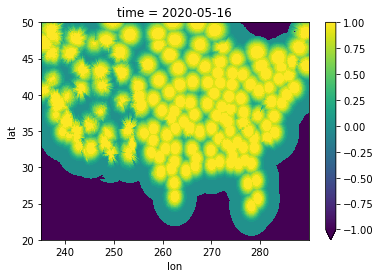

In [89]:
rq.plot(vmin=-1, vmax=1)

In [91]:
from src.regrid import *

In [92]:
tq4km = regrid_mrms(rq, 4, lats=(50, 20), lons=(235, 290))

In [210]:
tq4km.to_netcdf('/datadrive/mrms/4km/RadarQuality.nc')

In [90]:
# rq.plot(
#     projection=ccrs.PlateCarree(), project=True, 
#     cmap='blues', rasterize=True, dynamic=False, coastline=True, 
#     frame_width=500, vmax=1, vmin=-1)
# fig = plt.figure(figsize=(9,6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.gridlines()
# rq.plot(ax=ax, transform=ccrs.PlateCarree(),
#          vmin=-1, vmax=1)

In [32]:
360-100, 360-80

(260, 280)

In [33]:
45, 30

(45, 30)

## Preliminary work

In [298]:
tigge_tp = xr.open_mfdataset('/datadrive/tigge/32km/total_precipitation/*.nc').tp.diff('lead_time')

In [300]:
tigge_t = xr.open_mfdataset('/datadrive/tigge/32km/2m_temperature/*.nc')

In [304]:
xr.merge([tigge_tp, tigge_t]).to_array().isel(init_time=0, lead_time=0).values.shape

(2, 93, 172)

In [251]:
mrms = xr.open_mfdataset('/datadrive/mrms/4km/RadarOnly_QPE_06H/*.nc').tp

In [252]:
lead_time = np.timedelta64(12, 'h')

In [253]:
tigge = tigge.sel(lead_time=lead_time)

In [254]:
mrms

<xarray.DataArray 'tp' (time: 71, lat: 750, lon: 1376)>
dask.array<concatenate, shape=(71, 750, 1376), dtype=float32, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-05-01 ... 2020-05-18T12:00:00
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [255]:
tigge

<xarray.DataArray 'tp' (init_time: 825, lat: 93, lon: 172)>
dask.array<getitem, shape=(825, 93, 172), dtype=float32, chunksize=(62, 93, 172), chunktype=numpy.ndarray>
Coordinates:
  * init_time  (init_time) datetime64[ns] 2019-10-01 ... 2020-11-30T12:00:00
    lead_time  timedelta64[ns] 12:00:00
  * lon        (lon) float64 235.2 235.5 235.8 236.2 ... 289.0 289.3 289.6 289.9
  * lat        (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24

In [256]:
valid_time = tigge.init_time + tigge.lead_time

In [257]:
tigge.coords['valid_time'] = valid_time

In [258]:
tigge = tigge.swap_dims({'init_time': 'valid_time'})

In [259]:
overlap_times = np.intersect1d(mrms.time, valid_time)
overlap_times.shape

(36,)

In [260]:
overlap_times

array(['2020-05-01T00:00:00.000000000', '2020-05-01T12:00:00.000000000',
       '2020-05-02T00:00:00.000000000', '2020-05-02T12:00:00.000000000',
       '2020-05-03T00:00:00.000000000', '2020-05-03T12:00:00.000000000',
       '2020-05-04T00:00:00.000000000', '2020-05-04T12:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-05T12:00:00.000000000',
       '2020-05-06T00:00:00.000000000', '2020-05-06T12:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-07T12:00:00.000000000',
       '2020-05-08T00:00:00.000000000', '2020-05-08T12:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-09T12:00:00.000000000',
       '2020-05-10T00:00:00.000000000', '2020-05-10T12:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-11T12:00:00.000000000',
       '2020-05-12T00:00:00.000000000', '2020-05-12T12:00:00.000000000',
       '2020-05-13T00:00:00.000000000', '2020-05-13T12:00:00.000000000',
       '2020-05-14T00:00:00.000000000', '2020-05-14

In [249]:
val_days = 7

In [275]:
import pandas as pd
dt = pd.to_datetime(overlap_times)

In [278]:
dt.day <= val_days

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [282]:
overlap_times[~(dt.day <= val_days)]

array(['2020-05-08T00:00:00.000000000', '2020-05-08T12:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-09T12:00:00.000000000',
       '2020-05-10T00:00:00.000000000', '2020-05-10T12:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-11T12:00:00.000000000',
       '2020-05-12T00:00:00.000000000', '2020-05-12T12:00:00.000000000',
       '2020-05-13T00:00:00.000000000', '2020-05-13T12:00:00.000000000',
       '2020-05-14T00:00:00.000000000', '2020-05-14T12:00:00.000000000',
       '2020-05-15T00:00:00.000000000', '2020-05-15T12:00:00.000000000',
       '2020-05-16T00:00:00.000000000', '2020-05-16T12:00:00.000000000',
       '2020-05-17T00:00:00.000000000', '2020-05-17T12:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-18T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [148]:
mrms = mrms.sel(time=overlap_times)
tigge = tigge.sel(valid_time=overlap_times)

In [59]:
patch_size = 512
patch_tigge = 512 // 32
patch_mrms = 512 // 4
patch_tigge, patch_mrms

(16, 128)

(260.0, 261.0)

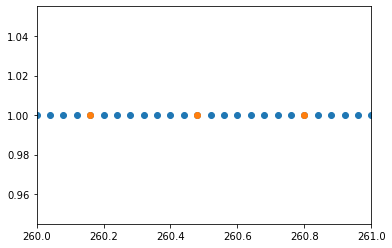

In [60]:
plt.scatter(mrms.lon, np.ones(len(mrms.lon)))
plt.scatter(tigge.lon, np.ones(len(tigge.lon)))
plt.xlim(260, 261)

In [95]:
tqmask = tq4km.coarsen(lat=patch_mrms, lon=patch_mrms, boundary='trim').min() >= 0

In [103]:
tqmask.hvplot.quadmesh(projection=ccrs.PlateCarree(), coastline=True, alpha=0.5)

:Overlay
   .QuadMesh.I  :QuadMesh   [lon,lat]   (value)
   .Coastline.I :Feature   [Longitude,Latitude]

In [104]:
nlat = len(tigge.lat) // patch_tigge
nlon = len(tigge.lon) // patch_tigge
nlat, nlon

(5, 10)

In [116]:
raw_idxs = np.array([g.flatten() for g in np.mgrid[:nlat, :nlon]]).T

In [121]:
idxs = np.array([r for r in raw_idxs if tqmask.isel(lat=r[0], lon=r[1])])

In [123]:
len(idxs), len(raw_idxs)

(36, 50)

In [152]:
len(mrms.time)

36

In [158]:
np.ones((len(idxs), 1)).shape, idxs.shape

((36, 1), (36, 2))

In [165]:
np.concatenate([
    np.concatenate(
        [np.ones((len(idxs), 1), dtype=int)*i, idxs], 1
    ) for i in range(len(mrms.time))
]).shape

(1296, 3)

## Constants

In [227]:
const = xr.open_dataset('/datadrive/tigge/raw/constants.nc')

In [228]:
const

<xarray.Dataset>
Dimensions:  (lat: 214, lon: 394)
Coordinates:
  * lat      (lat) float32 49.97 49.83 49.69 49.55 ... 20.45 20.31 20.17 20.03
  * lon      (lon) float32 235.1 235.2 235.3 235.5 ... 289.6 289.7 289.8 290.0
Data variables:
    orog     (lat, lon) float32 ...
    lsm      (lat, lon) float32 ...

In [230]:
c32 = regrid(const, 32, lats=(50, 20), lons=(235, 290))

using dimensions ('lat', 'lon') from data variable orog as the horizontal dimensions for this dataset.


In [231]:
c32.to_netcdf('/datadrive/tigge/32km/constants.nc')

In [232]:
c32

<xarray.Dataset>
Dimensions:  (lat: 93, lon: 172)
Coordinates:
  * lon      (lon) float64 235.2 235.5 235.8 236.2 ... 289.0 289.3 289.6 289.9
  * lat      (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
Data variables:
    orog     (lat, lon) float32 52.49 -4.248 176.7 492.5 ... -25.2 14.56 21.82
    lsm      (lat, lon) float32 0.3875 0.2462 0.6227 0.8174 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

## Actual dataloader

In [166]:
import torch
from torch.utils.data import Dataset

In [275]:
import pandas as pd
dt = pd.to_datetime(overlap_times)

In [278]:
dt.day <= val_days

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [282]:
overlap_times[~(dt.day <= val_days)]

array(['2020-05-08T00:00:00.000000000', '2020-05-08T12:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-09T12:00:00.000000000',
       '2020-05-10T00:00:00.000000000', '2020-05-10T12:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-11T12:00:00.000000000',
       '2020-05-12T00:00:00.000000000', '2020-05-12T12:00:00.000000000',
       '2020-05-13T00:00:00.000000000', '2020-05-13T12:00:00.000000000',
       '2020-05-14T00:00:00.000000000', '2020-05-14T12:00:00.000000000',
       '2020-05-15T00:00:00.000000000', '2020-05-15T12:00:00.000000000',
       '2020-05-16T00:00:00.000000000', '2020-05-16T12:00:00.000000000',
       '2020-05-17T00:00:00.000000000', '2020-05-17T12:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-18T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [454]:
class TiggeMRMSDataset(Dataset):
    def __init__(self, tigge_dir, tigge_vars, mrms_dir, lead_time=12, patch_size=512, rq_fn=None, 
                 const_fn=None, const_vars=None, val_days=None, split=None, scale=True,
                 mins=None, maxs=None):
        
        self.lead_time = lead_time
        self.patch_size = patch_size
        self.val_days = val_days
        self.split= split
        
        self.tigge = xr.merge([
            xr.open_mfdataset(f'{tigge_dir}/{v}/*.nc') for v in tigge_vars
        ])
        self.tigge['tp'] = self.tigge.tp.diff('lead_time')
        self.tigge['tp'] = self.tigge['tp'].where(self.tigge['tp'] >= 0, 0)
        self.tigge = self.tigge
        self.tigge = self.tigge.sel(lead_time=np.timedelta64(lead_time, 'h'))
        self.mrms = xr.open_mfdataset(f'{mrms_dir}/*.nc').tp
        self.mrms = self.mrms.where(self.mrms >= 0, 0)
        self._crop_times()
        self.tigge.load(); self.mrms.load()
        if scale:
            self._scale(mins, maxs)
        
        self.tigge_km = 32   # Currently hard-coded
        self.mrms_km = 4
        self.patch_tigge = self.patch_size // self.tigge_km
        self.patch_mrms = self.patch_size // self.mrms_km
        self._setup_indices()
        
        if rq_fn:
            self._create_rqmask(rq_fn)
        
        if const_fn:
            self.const = xr.open_dataset(const_fn).load()
            self.const_vars = const_vars
            if scale:
                const_mins = self.const.min()
                const_maxs = self.const.max()
                self.const = (self.const - const_mins) / (const_maxs - const_mins)
    
    def _scale(self, mins, maxs):
        self.mins = mins or self.tigge.min()
        self.maxs = maxs or self.tigge.max()
        
        # Min-max scaling
        self.tigge = (self.tigge - self.mins) / (self.maxs - self.mins)
        self.mrms = (self.mrms - self.mins.tp) / (self.maxs.tp - self.mins.tp)
        
    def _crop_times(self):
        valid_time = self.tigge.init_time + self.tigge.lead_time
        self.tigge.coords['valid_time'] = valid_time
        self.tigge = self.tigge.swap_dims({'init_time': 'valid_time'})
        self.overlap_times = np.intersect1d(self.mrms.time, self.tigge.valid_time)
        if self.val_days:
            dt = pd.to_datetime(self.overlap_times)
            self.overlap_times = self.overlap_times[
                dt.day <= self.val_days if self.split == 'valid' else dt.day > self.val_days
            ]
        self.mrms = self.mrms.sel(time=self.overlap_times)
        self.tigge = self.tigge.sel(valid_time=self.overlap_times)
        
    def _setup_indices(self):
        nlat = len(self.tigge.lat) // self.patch_tigge
        nlon = len(self.tigge.lon) // self.patch_tigge
        idxs = np.array([g.flatten() for g in np.mgrid[:nlat, :nlon]]).T
        if hasattr(self, 'tqmask'):
            idxs = np.array([r for r in raw_idxs if self.rqmask.isel(lat=r[0], lon=r[1])])
        # Now add time indices
        self.ntime = len(self.overlap_times)
        self.idxs = np.concatenate([
            np.concatenate(
                [np.ones((len(idxs), 1), dtype=int)*i, idxs], 1
            ) for i in range(self.ntime)
        ])
    
    def _create_rqmask(self, rq_fn):
        rq = xr.open_dataset(rq_fn)
        self.tqmask = rq.coarsen(lat=self.patch_mrms, lon=self.patch_mrms, boundary='trim').min() >= 0
        
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        time_idx, lat_idx, lon_idx = self.idxs[idx]
        X = self.tigge.to_array().isel(
            valid_time=time_idx,
            lat=slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge),
            lon=slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge)
        ).values
        if hasattr(self, 'const'):
            X = self._add_const(X, lat_idx, lon_idx)
        y = self.mrms.isel(
            time=time_idx,
            lat=slice(lat_idx * self.patch_mrms, (lat_idx+1) * self.patch_mrms),
            lon=slice(lon_idx * self.patch_mrms, (lon_idx+1) * self.patch_mrms)
        ).values[None]
        return X, y
    
    def _add_const(self, X, lat_idx, lon_idx):
        Xs = [X]
        Xs.append(self.const[self.const_vars].to_array().isel(
            lat=slice(lat_idx * self.patch_tigge, (lat_idx+1) * self.patch_tigge),
            lon=slice(lon_idx * self.patch_tigge, (lon_idx+1) * self.patch_tigge)
        ))
        return np.concatenate(Xs)
    
    
    def compute_weights(self, bins=np.append(np.arange(0, 0.1, 0.01), 10)):
        mean_precip = []
        for idx in range(len(self.idxs)):
            X, y = self[idx]
            mean_precip.append(y.mean())
        bin_weight = np.histogram(mean_precip, bins=bins)[0]
        bin_weight = 1 / np.maximum(bin_weight, 1)
        bin_idxs = np.digitize(mean_precip, bins) - 1
        weights = bin_weight[bin_idxs]
        return weights

In [42]:
from src.dataloader import *

In [58]:
ds = TiggeMRMSDataset(
    tigge_dir='/datadrive/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    val_days=7,
    split='train',
    tp_log=1
)

In [59]:
X, y = ds[100]

In [60]:
X.shape, y.shape

((1, 16, 16), (1, 128, 128))

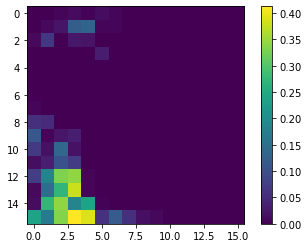

In [61]:
plt.imshow(X[0])
plt.colorbar()

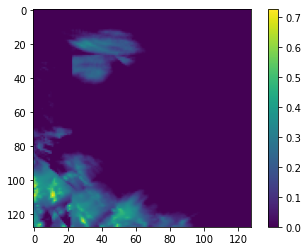

In [62]:
plt.imshow(y[0])
plt.colorbar()

In [19]:
ds.tigge.isel(lat=slice(0, -0 or None))

<xarray.DataArray (variable: 1, valid_time: 148, lat: 93, lon: 172)>
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 1.4163724e-05, 0.0000000e+00, ...,
          2.3995619e-04, 9.0957951e-04, 7.3818550e-03],
         [4.6953987e-06, 0.0000000e+00, 0.0000000e+00, ...,
          4.7275177e-04, 2.2011402e-03, 1.2602209e-02],
         [2.4031731e-06, 0.0000000e+00, 0.0000000e+00, ...,
          4.0699782e-05, 3.9626881e-03, 5.1598554e-03]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          3.6665061e-03, 1.7230222e-03, 3.6082606e-04],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.1291927e-02, 5.2729542e-03, 1.0196529e-03],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          2.1907968e-02, 9.8337103e-03, 1.8595970e-03],
...
         [9.6640164e-05, 9.7020886e-05, 1.5403292e-04, ...,
          0.0000000e+00, 0.0000000e+00, 3.7637726e-06],
         [3.7790218e-04, 3.1593352e-04, 3.8191624e-04, ...,
          0.0000000e+00, 7.9861557e-06, 1.2809543e-05],
         [5.3928629e-04, 7.1165914e-04, 9.4844011e-04, ...,
          3.0343372e-05, 1.3139503e-04, 3.8070881e-04]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.9434454e-04, 1.1941658e-04, 6.2187522e-05],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          9.1722235e-05, 4.7201502e-05, 3.6659283e-05],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.8978080e-04, 2.0914280e-04, 1.5266580e-04],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          3.8155401e-04, 8.9493912e-04, 1.3079927e-03],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.3911166e-03, 6.0826825e-04, 4.7360890e-04],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          6.5956044e-04, 2.8948963e-03, 1.0862098e-03]]]], dtype=float32)
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-05-07T12:00:00 ... 2020-08-11
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
  * valid_time  (valid_time) datetime64[ns] 2020-05-08 ... 2020-08-11T12:00:00
  * variable    (variable) <U2 'tp'

In [8]:
ds.patch_tigge

16

In [9]:
93%16

13

In [10]:
172%16

12

In [50]:
i = iter(ds)

In [51]:
%lprun -f ds.__getitem__ ds[0]

Timer unit: 1e-06 s

Total time: 0.005362 s
File: /home/stephan/nwp-downscale/notebooks/src/dataloader.py
Function: __getitem__ at line 117

Line #      Hits         Time  Per Hit   % Time  Line Contents
   117                                               def __getitem__(self, idx):
   118                                                   """Return individual sample. idx is the sample id, i.e. the index of self.idxs."""
   119         1          8.0      8.0      0.1          if torch.is_tensor(idx):
   120                                                       idx = idx.tolist()
   121         1         14.0     14.0      0.3          time_idx, lat_idx, lon_idx = self.idxs[idx]
   122                                           
   123                                                   # Get features for given time and patch
   124         2       3168.0   1584.0     59.1          X = self.tigge.isel(
   125         1          1.0      1.0      0.0              valid_time=time_idx,
   12

In [52]:
%%time
ds[0]

CPU times: user 1.49 ms, sys: 242 µs, total: 1.74 ms
Wall time: 1.75 ms


(array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0.,

In [55]:
len(ds)

5328

In [56]:
weights = ds.compute_weights()

In [57]:
sampler = torch.utils.data.WeightedRandomSampler(weights, len(ds))

In [58]:
dl = torch.utils.data.DataLoader(ds, batch_size=32, sampler=sampler)

In [59]:
i = iter(dl)

In [60]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [61]:
%timeit X, y = next(i)

38.8 ms ± 927 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
i.__next__

In [31]:
i.dataset

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'dataset'

In [32]:
%lprun -f i._dataset_fetcher.fetch next(i)

Timer unit: 1e-06 s

Total time: 0.231269 s
File: /home/stephan/.conda/envs/stephan/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py
Function: fetch at line 42

Line #      Hits         Time  Per Hit   % Time  Line Contents
    42                                               def fetch(self, possibly_batched_index):
    43         1          1.0      1.0      0.0          if self.auto_collation:
    44         1     229955.0 229955.0     99.4              data = [self.dataset[idx] for idx in possibly_batched_index]
    45                                                   else:
    46                                                       data = self.dataset[possibly_batched_index]
    47         1       1313.0   1313.0      0.6          return self.collate_fn(data)

In [24]:
len(dl)

167

In [25]:
167*0.2

33.4

In [544]:
X, y = next(iter(dl))

In [545]:
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 128, 128]))

In [546]:
y.mean()

tensor(0.0025)

In [445]:
len(mean_precip), np.histogram(mean_precip, bins=bins)[0].sum()

(2500, 2500)

In [449]:
np.histogram(mean_precip, bins=bins)[0]

array([2243,  158,   61,   19,   10,    6,    2,    1,    0,    0])

In [439]:
bins = np.append(np.arange(0, 0.1, 0.01), 10)
weight = np.histogram(mean_precip, bins=bins)[0]
weight = np.maximum(weight, 1)
weight = 1 / weight
weight

array([4.45831476e-04, 6.32911392e-03, 1.63934426e-02, 5.26315789e-02,
       1.00000000e-01, 1.66666667e-01, 5.00000000e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

In [450]:
bin_idxs = np.digitize(mean_precip, bins) - 1
bin_idxs

array([0, 0, 0, ..., 0, 0, 0])

In [453]:
weight_idxs = weight[bin_idxs]
weight_idxs

array([0.00044583, 0.00044583, 0.00044583, ..., 0.00044583, 0.00044583,
       0.00044583])

In [440]:
from scipy import stats

In [441]:
stats.binned_statistic(mean_precip, mean_precip, bins=bins)

BinnedStatisticResult(statistic=array([0.00137684, 0.01386141, 0.02418009, 0.03405307, 0.04363112,
       0.05469953, 0.06557816, 0.07960159,        nan,        nan]), bin_edges=array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09, 10.  ]), binnumber=array([1, 1, 1, ..., 1, 1, 1]))

In [428]:
np.append(np.arange(0, 1, 0.1), 10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9, 10. ])

In [434]:
np.histogram(mean_precip, bins=np.append(np.arange(0, 0.1, 0.01), 10))

(array([2243,  158,   61,   19,   10,    6,    2,    1,    0,    0]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09, 10.  ]))

In [433]:
np.histogram(mean_precip, bins=np.append(np.arange(0, 0.1, 0.01), 10), density=True)

(array([8.972e+01, 6.320e+00, 2.440e+00, 7.600e-01, 4.000e-01, 2.400e-01,
        8.000e-02, 4.000e-02, 0.000e+00, 0.000e+00]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09, 10.  ]))

In [435]:
1 / np.histogram(mean_precip, bins=np.append(np.arange(0, 0.1, 0.01), 10), density=True)[0]

<ipython-input-435-d870de6f32d1>:1: RuntimeWarning: divide by zero encountered in true_divide
  1 / np.histogram(mean_precip, bins=np.append(np.arange(0, 0.1, 0.01), 10), density=True)[0]


array([1.11457869e-02, 1.58227848e-01, 4.09836066e-01, 1.31578947e+00,
       2.50000000e+00, 4.16666667e+00, 1.25000000e+01, 2.50000000e+01,
                  inf,            inf])

In [437]:
2.50000000e+01 / 1.11457869e-02

2242.999998501676

(array([1.575e+03, 6.680e+02, 1.580e+02, 6.100e+01, 1.900e+01, 1.000e+01,
        6.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00]),
 array([0.   , 0.001, 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 ,
        0.08 , 0.09 , 0.1  ]),
 <BarContainer object of 11 artists>)

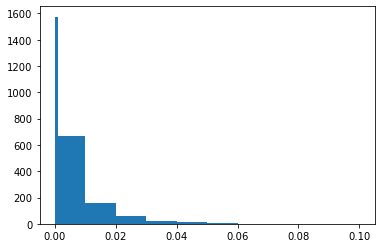

In [426]:
plt.hist(mean_precip, bins=[0, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

In [396]:
len(ds), ds.ntime

(2500, 50)

In [397]:
X, y = ds[1000]

In [400]:
X.std((1, 2))

array([0.01055218, 0.05442769, 0.13426466, 0.33147842], dtype=float32)

In [386]:
ds.mins

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
Data variables:
    tp         float32 0.0
    t2m        float32 259.8

In [387]:
X.shape, y.shape

((4, 16, 16), (128, 128))

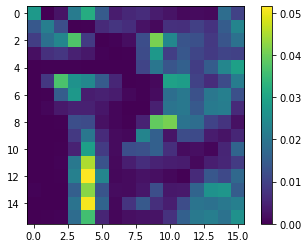

In [388]:
plt.imshow(X[0]); plt.colorbar();

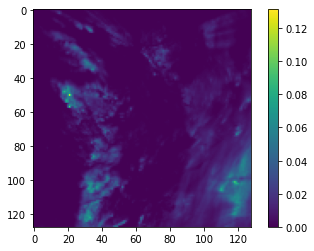

In [389]:
plt.imshow(y); plt.colorbar();